In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv
/kaggle/input/siyam-rupali-text/Siyamrupali.ttf


# **Updating/Instaling Libraries**

In [2]:
#!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl

     |████████████████████████████████| 103 kB 5.7 MB/s 
     |████████████████████████████████| 242 kB 4.5 MB/s 


In [3]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 


from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

2021-10-19 15:50:11.751381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# **Loading Dataset**

In [4]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [5]:

df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
display(df_train)
df_train.head()
df_train.describe()
df_train.info()
print(df_train.category.unique())

,category,text,cleanText,count
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
 3   count      98883 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


In [6]:
display(df_test)
df_test.head()
df_test.describe()
df_test.info()

,category,text,cleanText,count
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
 3   count      98884 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [7]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

# **Stopwords Removal**

In [8]:
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
display(data1)
stop = data1['words'].tolist()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [9]:
df_train['cleanText'] = df_train.cleanText.apply(lambda x: stopwordRemoval(str(x)))


In [10]:
df_test['cleanText'] = df_test.cleanText.apply(lambda x: stopwordRemoval(str(x)))

# **Stemming**

In [11]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [12]:
#df_train['cleanText']=df_train['cleanText'].apply(stem_text)
#df_test['cleanText']=df_test['cleanText'].apply(stem_text)

# **Changing Labels to Numbers**

In [13]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

df_train["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
df_test["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বাণিজ্য সংস্থা ডব্লিউটিও মহাপর...,293
1,1,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবাদমাধ্যমগুলো নে...,206
2,2,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের প্রদেশ ঐতিহাসিক স্থানে...,167
3,3,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকারি বিদ্যালয...,181
4,1,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক বাক্যের অর্থটা সে...,148
...,...,...,...,...
98878,6,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ মহিলা ময়মন...,389
98879,5,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে পূর্ণ অমিতাভ বচ্চন জন্মদিন এক...,147
98880,4,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশলী মাইক্রোসফটে ...,673
98881,4,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,161


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ র লেগ স্প...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় পাঠানোর প্রস...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার অ্যালবাম রঙমিস্ত্রী প্রকাশনা উত্...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের ব্যবহারকারীর তথ্য চুরি বিক্রির বিজ্ঞা...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল বিকাশের পরিশোধ ...,14


# **Removing Null values**

In [14]:
#display non-null values
df_train = df_train.dropna()
df_test = df_test.dropna()

# **Removing Small Texts**

In [15]:
#counting text length
df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
# Remove the text with words less than 5
df_train= df_train.loc[df_train['count']>5]
df_test= df_test.loc[df_test['count']>5]

# **Shuffle Dataset**

In [16]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,2,ইরাকে যুদ্ধের সময় দেশটির সাধারণ মানুষের ওপর নি...,ইরাকে যুদ্ধের সময় দেশটির মানুষের ওপর নির্যাতন ...,236
1,4,বিসিএস কম্পিউটার সিটির বার্ষিক মেলা ‘সিটিআইটি ...,বিসিএস কম্পিউটার সিটির বার্ষিক মেলা সিটিআইটি ব...,120
2,5,সিলেট নগরের রিকাবীবাজার এলাকার কবি নজরুল অডিটো...,সিলেট নগরের রিকাবীবাজার কবি নজরুল অডিটোরিয়ামে ...,44
3,2,জাতিসংঘের সাধারণ পরিষদের মানবাধিকারবিষয়ক কমিট...,জাতিসংঘের পরিষদের মানবাধিকারবিষয়ক কমিটিতে বুধ...,97
4,3,বিশ্বের ৪৬টি দেশে ৬৫ বছরের বেশি বয়সী প্রবীণের...,বিশ্বের দেশে বছরের বয়সী প্রবীণেরা কষ্টে আছেন ...,254
...,...,...,...,...
98595,6,এক জাদুঘরে একজন কৌতুহলী শিক্ষার্থী অবাক হয়ে এ...,জাদুঘরে একজন কৌতুহলী শিক্ষার্থী অবাক ডাইনোসরের...,33
98596,6,"Guided writingপ্রিয় শিক্ষার্থীরা, আজ ইংরেজি ১...",প্রিয় শিক্ষার্থীরা ইংরেজি পত্রের অর্থাৎ প্রশ্...,20
98597,3,ঠাকুরগাঁওয়ে বিলুপ্ত প্রজাতির দুটি লক্ষ্মীপ্যাঁ...,ঠাকুরগাঁওয়ে বিলুপ্ত প্রজাতির লক্ষ্মীপ্যাঁচা উদ...,155
98598,0,বাংলাদেশের টেক্সটাইল খাতে জাপানি বিনিয়োগের আহ...,বাংলাদেশের টেক্সটাইল খাতে জাপানি বিনিয়োগের আহ্...,254


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...,243
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ র লেগ স্প...,117
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...,61
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...,165
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় পাঠানোর প্রস...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার অ্যালবাম রঙমিস্ত্রী প্রকাশনা উত্...,151
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের ব্যবহারকারীর তথ্য চুরি বিক্রির বিজ্ঞা...,147
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল বিকাশের পরিশোধ ...,13


In [17]:
train_sentences=df_train['cleanText'].values
train_labels=df_train['category'].values

In [18]:
test_sentences=df_test['cleanText'].values
test_labels=df_test['category'].values

In [19]:
print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 98600
Testing Set Length: 98575
train_labels shape: (98600,)
test_labels shape: (98575,)


# **Train/Test/Validation Set**
**This dataset contains two csv files. One is Train set and another is Test set.IN EDA,we have seen that train and test set is equal sized and distribution of class is identical to both of the test and train set.
I have used full train set for training and used 20% of the data from testset for validation set and 80% for testing
The validation set and the Test set is partitioned into stratified fashion to keep the distribution of class intact.**

In [20]:
test_sentences, validation_sentences,test_labels, validation_labels = train_test_split(test_sentences, test_labels,stratify=test_labels,test_size=0.2)

In [21]:
train_labels=keras.utils.to_categorical(train_labels)
test_labels=keras.utils.to_categorical(test_labels)
validation_labels=keras.utils.to_categorical(validation_labels)


print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("validation_sentences shape: "+str(validation_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 98600
Testing Set Length: 98575
training_sentences shape: (98600,)
testing_sentences shape: (78860,)
validation_sentences shape: (19715,)
train_labels shape: (98600, 7)
test_labels shape: (78860, 7)
validation_labels shape: (19715, 7)


In [22]:
print(train_sentences[1])
print(train_labels[0])

বিসিএস কম্পিউটার সিটির বার্ষিক মেলা সিটিআইটি বৃহস্পতিবার গেম প্রতিযোগিতার চূড়ান্ত পর্ব ফাইনাল খেলা আগামীকাল শুক্রবার গিগাবাইট আয়োজিত প্রতিযোগিতায় নিড স্পিড ফিফা কাউন্টার স্ট্রাইক ডিউটি গেমে গেমার নেন মেলার চিত্রাঙ্কন প্রতিযোগিতার নিবন্ধনের মেলায় ধরনের প্রযুক্তিপণ্যের দর্শকদের আগ্রহ প্রসেসর প্রতিও ইন্টেলের পিডিসি গিগাহার্টজ কোর সেলেরন কোরআই থ্রিসহ প্রসেসর এএমডির সেমপ্রোন এপিইউ বুলডোজারও মেলায় মেলায় কম্পিউটার কেনার চাহিদাও ড্রিমল্যান্ড কম্পিউটার টাকায় দিচ্ছে পার্সোনাল কম্পিউটার রায়ানস কম্পিউটার টাকায় বিক্রি কম্পিউটার জেএএন অ্যাসোসিয়েটস ক্যানন প্রিন্টারে দিচ্ছে মূল্য ছাড় ক্যানন পিক্সমা এমজি ইঙ্কজেট মাল্টি ফাংশন প্রিন্টার টাকায় এলবিপি লেজার প্রিন্টার টাকায় প্রতিটি এসার নেটবুক নোটবুক ট্যাবলেট পিসির থাকছে র ্যাফল ড্র কুপন মেলা শেষে ড্রয়ের পুরস্কার সিঙ্গাপুর মালয়েশিয়া নেপাল ভ্রমণের টিকিট সন্ধ্যার মেলার আয়োজকদের উদ্যোগে অনুষ্ঠিত নাটক পাদুকা বর্জন হঠাৎ নাট্য সম্প্রদায় এটির মঞ্চায়ন রাহিতুল ইসলাম
[0. 0. 1. 0. 0. 0. 0.]


# **Tokenization**

In [23]:
vocab_size = 100000
embedding_dim = 150
max_length = 600
trunc_type='post'
oov_tok = "<OOV>"

print(train_sentences.shape)
print(train_labels.shape)


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#464246 words in raw dataset
#463651 words in raw dataset after stopwords removal
#***** after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

(98600,)
(98600, 7)
463635
Word index length:463635


# **After Tokenization Data visualization**

In [24]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

সিলেট নগরের রিকাবীবাজার কবি নজরুল অডিটোরিয়ামে সোমবার নাট্যদল থিয়েটার বাংলা মঞ্চায়ন বিশ্বখ্যাত ফরাসি নাট্যকার মলিয়েরের ম্যারিজ ফোর্স নাটকটি সন্ধ্যা সাড়ে ছয়টায় মঞ্চনাটকটির উদ্বোধনী অনুষ্ঠিত নাটকের নবরূপায়ণ নির্দেশনা নাট্যকার মোস্তাক আহমেদ নির্দেশক নাটকটি সংগঠনের প্রযোজনা সিলেটের দর্শকেরা নাটকটি ভালোভাবে উচ্ছ্বসিত শিগগিরই নাটকটির দ্বিতীয় মঞ্চায়ন অনুষ্ঠিত

Sentence Tokenized and Converted into Sequence :--> 

[990, 1089, 59211, 874, 1007, 14854, 132, 10700, 2318, 105, 8376, 6240, 2224, 6679, 1, 94009, 10701, 1961, 430, 175, 5066, 1, 1060, 81, 828, 1, 885, 6679, 15896, 89, 5387, 1961, 797, 1646, 2569, 2558, 1961, 1959, 4326, 1181, 3172, 73, 8376, 81]

After Padding the Sequence with padding length 100 :--> 

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0    

In [25]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (98600, 600)
Padded shape(testing): (78860, 600)


# **Model Creation**

In [26]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

2021-10-19 15:58:27.205879: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 15:58:27.209607: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 15:58:27.253977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 15:58:27.254644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-19 15:58:27.254717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 15:58:27.285957: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 150)          15000000  
_________________________________________________________________
dense (Dense)                (None, 600, 50)           7550      
_________________________________________________________________
dense_1 (Dense)              (None, 600, 25)           1275      
_________________________________________________________________
dense_2 (Dense)              (None, 600, 20)           520       
_________________________________________________________________
flatten (Flatten)            (None, 12000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 84007     
Total params: 15,093,352
Trainable params: 15,093,352
Non-trainable params: 0
____________________________________________

In [27]:
history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=( validation_padded,validation_labels),use_multiprocessing=True, workers=8)

2021-10-19 15:58:30.286438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 15:58:30.298600: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/10


2021-10-19 15:58:31.032575: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19 15:58:31.855960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


386/386 [==============================] - 108s 275ms/step - loss: 2.1337 - accuracy: 0.1767 - val_loss: 1.9219 - val_accuracy: 0.3853
Epoch 2/10
386/386 [==============================] - 105s 273ms/step - loss: 1.6087 - accuracy: 0.5834 - val_loss: 0.8922 - val_accuracy: 0.8102
Epoch 3/10
386/386 [==============================] - 106s 273ms/step - loss: 0.7798 - accuracy: 0.8458 - val_loss: 0.6005 - val_accuracy: 0.8907
Epoch 4/10
386/386 [==============================] - 105s 273ms/step - loss: 0.5328 - accuracy: 0.9088 - val_loss: 0.4948 - val_accuracy: 0.9077
Epoch 5/10
386/386 [==============================] - 106s 274ms/step - loss: 0.4275 - accuracy: 0.9305 - val_loss: 0.4441 - val_accuracy: 0.9173
Epoch 6/10
386/386 [==============================] - 107s 277ms/step - loss: 0.3683 - accuracy: 0.9442 - val_loss: 0.4151 - val_accuracy: 0.9220
Epoch 7/10
386/386 [==============================] - 107s 276ms/step - loss: 0.3263 - accuracy: 0.9533 - val_loss: 0.3958 - val_accura

# **Learning Curve**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


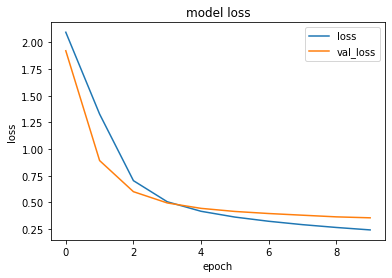

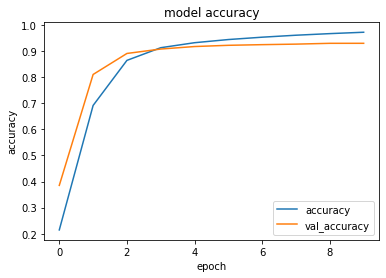

In [28]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


# **Evaluation**

In [29]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

386/386 [==============================] - 9s 24ms/step - loss: 0.2249 - accuracy: 0.9772
The train accuracy is: 0.977180540561676
309/309 [==============================] - 8s 24ms/step - loss: 0.3616 - accuracy: 0.9298
The test accuracy is: 0.9297996163368225


In [30]:
predictions = model.predict(testing_padded)

In [31]:
predictions = np.argmax(predictions, axis=-1) 

In [32]:
test_labels=np.argmax(test_labels, axis=-1)

In [33]:
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels,predictions, average='weighted')
print("Precision :"+str(precision))
print("Recall :"+str(recall))
print("fscore :"+str(fscore))

Precision :0.9300842455648933
Recall :0.9297996449404007
fscore :0.9298866212424677


# **Confusion Matrix & Classification Report**

,precision,recall,f1-score,support
economy,90.93,90.81,90.87,11583.0000
sports,99.04,97.46,98.24,12692.0000
international,93.36,93.74,93.55,12251.0000
state,89.52,88.43,88.97,12146.0000
technology,87.41,90.82,89.08,7948.0000
entertainment,94.95,95.83,95.39,12194.0000
education,93.65,92.64,93.14,10046.0000
accuracy,92.98,92.98,92.98,0.9298
macro avg,92.69,92.82,92.75,78860.0000
weighted avg,93.01,92.98,92.99,78860.0000


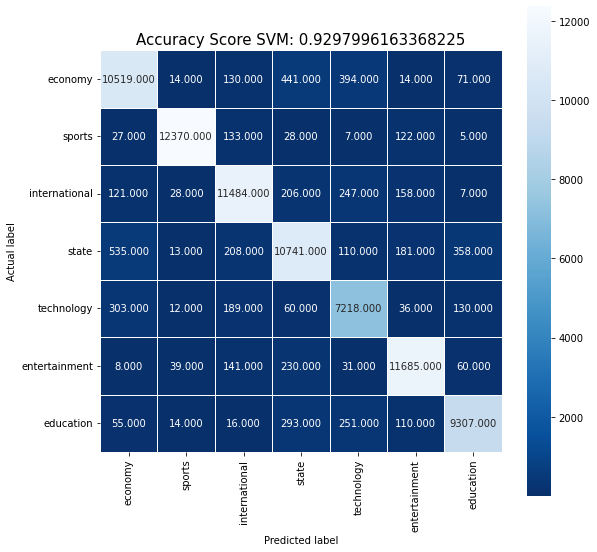

In [34]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

cm = metrics.confusion_matrix(test_labels,predictions)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,index = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'], 
                     columns = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'])

plt.figure(figsize=(9,9))
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score ANN: {0}'.format(loss_and_metrics[1])
plt.title(all_sample_title, size = 15);

report = pd.DataFrame(classification_report(y_true = test_labels, y_pred = predictions, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'sports','2':'international','3':'state','4':'technology','5':'entertainment','6':'education'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
display(report)